# Phase transition diagrams

In this notebook, **phase transition diagrams** of the  $\ell_1$ minimization procedure Basis Pursuit (BP)  are drawn for various type of random measurements matrices. 

An example of a phase transition diagram is as follows
<img src="exp_power_1_100.png">
In this example, we are interested in the reconstruction of sparse signals of size $N=100$. For every pixel indexed by a couple $(m,s)$ ($m$: number of measurements, $s$: sparsity parameter), we construct $15$ signals in $\mathbb{R}^N$ with sparsity $s$ and we observed $m$ linear measurements for each one of those signals. In the example, the measurement vectors were constructed from $N$ i.i.d. *exponential symmetric* random variables. Every time the Basis Pursuit procedure reconstructs all of the $15$ signals, a red pixel is drawn. When none of the $15$ signals are recovered a blue pixel is drawn. And for every results in between, an other color is drawn. 

Phase transition diagrams are used for at least two reasons:
> 1) compare procedures (like BP, IHT, OMP, etc) and algorithms used to implement those procedures

> 2) compare measurement matrices (constructed from various random variables or structured measurements or determinsitic matrices)

The idea is that procedures / algorithms / measurement matrices are better when their phase transition curves (obtained when the number of failures becomes larger than the number of successes) are lower. For instance, below are plotted phase transition curves for various measurements matrices.
<img src="phase_transition_curves_exp_power_100_v3.png">
One can see that measurements matrices with *exponential power $2$* are better.


In this notebook, we are going to only focus on Point 2), i.e. to compare sensing matrix by their phase transitions.

In [3]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

## A bit of theory

Recall that $x$ is the unique solution to (BP) if the null space of $A$ misses the 
cone of descent $\mathcal{D}_{\|\cdot\|_1}(x)$. What makes a Gaussian map special is that its null space is 
uniformly distributed among the set of all $(n-m)$-dimensional subspaces in $\mathbb{R}^n$. It turns out that Gordon 
gave a precise estimate of the probability that a random uniform subspace misses a convex cone. To state Gordon’s 
result, we need the notion of Gaussian width of a set $K\subset \mathbb{R}^n$ defined as:
$$ \omega(K) := \mathbb{E}_g \sup_{z\in K \cap S^{n-1}} \left\langle g , z \right\rangle,
$$ 
where $S^{n-1}$ is the unit sphere of $\mathbb{R}^n$ and the expectation is taken over $g\sim \mathcal{N}(0,\text{Id})$. To the best of the author’s 
knowledge, Rudelson and Vershynin were the first to recognize the importance of Gordon’s result in this 
context.

__Theorem (Gordon's escape through the mesh theorem)__
> Let $K\subset \mathbb{R}^n$ be a cone and $A\in \mathbb{R}^{m\times n}$ be a Gaussian map.If
$$ m \geq (\omega(K) + t)^2 +1
$$
then $\ker(A) \cap K = \{0\}$ with probability at least $1-e^{-t^2/2}$.


Hence, Gordon’s theorem allows to conclude that slightly more than $\omega(\mathcal{D}_{\|\cdot\|_1}(x)$ Gaussian measurements are sufficient to recover a signal $x$ whose cone of descent is $\mathcal{D}_{\|\cdot\|_1}(x)$.



__Estimating the Gaussian width__
For Gordon's theorem to be useful we need tools to calculate these widths. One popular way of providing an upper bound on the Gaussian width of a descent cone is via polarity. The polar cone to a cone $\mathcal{D}\subset \mathbb{R}^n$ is defined by
$$
\mathcal{D}^\circ := \left\{ d \in \mathbb{R}^n : \left\langle d, z \right\rangle \leq 0,\quad \forall z\in \mathcal{D} \right\}
$$



For us, the cone polar to the cone of descent is the set of all directions $t \eta$ where $t>0$ and $\eta \in \partial {\|\cdot\|_1}(x)$. With this, convex duality gives
$$ \omega^2(\mathcal{D}_{\|\cdot\|_1}(x)) \leq \mathbb{E}_g \min_{z\in \mathcal{D}_{\|\cdot\|_1}(x)^\circ} \|g-z\|_2^2.
$$
For ease of notation, let us set $ \mathcal{D} = \mathcal{D}_{\|\cdot\|_1}(x)$.
In words, the right-hand side is the average squared distance between a random Gaussian vector and the cone $\mathcal{D}$, and is called the statistical dimension of the descent cone denoted by $\delta(\mathcal{D})$. (One can can check that $\delta(\mathcal{D}) = \mathbb{E}_g \| \Pi_{\mathcal{D}}(g) \|_2^2 $ where $\Pi$ is the projection onto the convex cone $\mathcal{D}^\circ$). {\color{PineGreen} Draw it!}.
 The point is that the statistical dimension of $\mathcal{D}^\circ$  is often relatively easy to calculate for some usual norms such as the $\ell^1$ norms (it is left as an exercise).
 
 A beautiful fact is that the statistical dimension provides a sharp transition between success and failure of the convex program (BP), as made very clear by the following theorem taken from Amelunxen, Lotz, McCoy and Tropp's paper.

__ Theorem [ALMT 2015]__
> Let $x\in \mathbb{R}^n$ be a fixed vector, $\|\cdot\|$ a norm, and $\delta(\mathcal{D})$ be the cone of descent at $x$. Suppose $A$ is a Gaussian map and let $y = Ax$. Then for a fixed tolerance $\varepsilon \in  ]0, 1[$,
1. $m \leq \delta(\mathcal{D}) -a_\varepsilon \sqrt{n} \Longrightarrow$ (BP) succeeds with probability $\leq \varepsilon$,
+ $m \geq \delta(\mathcal{D}) +a_\varepsilon \sqrt{n} \Longrightarrow$ (BP) succeeds with probability $\geq 1-\varepsilon$,
\end{enumerate}
with $a_\varepsilon = \sqrt{8\log (4/\varepsilon)}$.


In other words, there is a phase transition of width at most a constant times root n around the statistical dimension.

In this practical work, we are only going to give an __empirical__ phase transition for Gaussian matrices.

## Generation of (random) sparse signals



In [4]:
def signal(N, s):
    """Construct a signal of lenght n with s gaussian variables localized randomly and zeros everywhere else"""
    x = np.zeros(N)
    sel = np.random.permutation(N)[0:s]
    x[sel] = np.random.randn(s)
    return x

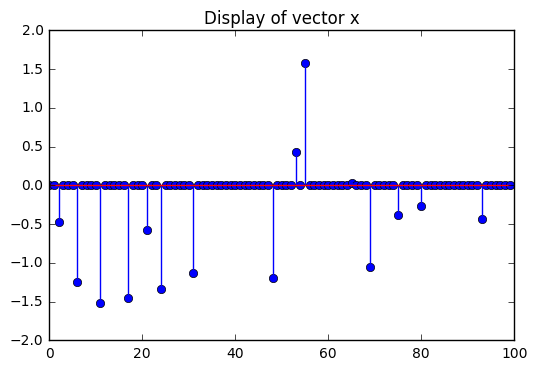

In [5]:
# Example of use
x = signal(100,15)

plt.stem(x)
titre = 'Display of vector x'
plt.title(titre)

## Generation of random sensing matrices


We construct various random measurement matrices:  

1) The first one is constructed using power of Gaussian random variables: that is the measurement matrix $A$ is populated with i.i.d.\ random variables like $${\rm sign}(g) |g|^p$$ where $g$ is a standard Gaussian variable and $p\geq1$ is some power.

2) The second one are Student variable with degree $p$. That is a random variable absolutely continuous with a density of the order of  $(1+t)^{-(p+1)}$.



In [6]:
def measurement_matrix(m, N, rand_type = "gauss", power = 2):
    if rand_type == "student":
        A = np.random.standard_t(power, size=(m, N))
    else:
        A = np.random.randn(m, N)
        A = np.multiply(np.power(np.absolute(A),power), np.sign(A))          
    return A 

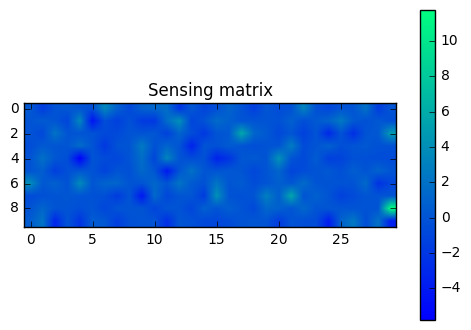

In [10]:
A = measurement_matrix(10, 30, rand_type = "gauss")#, power = 4)
plt.figure()
plt.imshow(A, cmap='winter')
plt.title('Sensing matrix')
plt.colorbar()

## Phase transition diagrams for (BP)

For reconstructing the $s$-sparse signal $x$, we are going to solve the Basis Pursuit (BP):
$$ \min_{z\in \mathbb{R}^n} \|z\|_1 \qquad \text{s.t.} \qquad Ax=Az
$$
To solve (BP), we are going to use the Douglas-Rachford algorithm, that you have already coded during Practical Work \#2.

In [18]:
def proxL1(x, gamma):
    return np.fmax(0, 1 - gamma / np.fmax(1e-15, np.abs(x))) * x

def DRmethod(y, A, n_it=100, version=1):
    n = A.shape[1]
    
    pA = A.T.dot(np.linalg.inv( A.dot(A.T) ))
    AX = np.eye(n) - pA.dot(A)
    Ay = pA.dot(y)
    proxA = lambda x: AX.dot(x) + Ay
    
    if version == 1:
        proxf = lambda x, s: proxL1(x, s)
        proxg = lambda x, s: proxA(x)
    else:
        proxf = lambda x, s: proxA(x)
        proxg = lambda x, s: proxL1(x, s)
    
    z = np.zeros(n)  # Initial point
    mu, s = 1, 1  # Relaxation and step size
    
    obj = []
    for it in range(n_it):
        x = proxf(z, s)
        z = z + mu*(proxg(2*x-z, s) - x)
        obj.append( np.linalg.norm(x, ord=1) )
    return x, obj

We say that the reconstruction is successful when $$||x-x_{recover}||_2\leq 0.001.$$


__ Exercise 1__

Fill the blanks in the following code, for a certain type of sensing matrices, we want 

1. a number of measurements $m$ to go from 1 to N,
+ to construct a given sensing matrix $A \in \mathbb{R}^{m\times n}$ of the specified type
+ test its recovery ability via (BP) to reconstruct signals which sparsity $s$ is going from $m+1$ to $N/2$.

To test the recovery success, one should perform 'nbtest' reconstructions tests without changing parameters $m,A,s$. One could fix 'nbtest' to be 15.



In [31]:

def phase_transition_mat(N, nbtest, rand_type = "gauss", power = 2):
    """return a n.n/2 matrix with the number of reconstruction success for every  1\leq m \leq n measurements 
    and sparsity 1\leq sparsity \leq n/2
    N : ambiant dimension of the signals
    nbtest : number of tests for each pixel"""
    PTM = np.zeros((N,int(N/2)))
    set_ind_failure = []
    for m in range(1,N+1):#construct one line of the Phase transition matrix for a given number of measurements m
        if (m % 20) == 0:
            print("line number {} done".format(m))
        A = measurement_matrix(m, N, rand_type, power)
        ind_failure = 0
        for sparsity in range(1,min(m+1, int(N/2))+1):
            nb_success = 0         
            for i in range(nbtest):
                x = signal(N, sparsity)
                y = np.dot(A,x)
                sol, obj = DRmethod(y, A, n_it=100, version=1)
                if np.linalg.norm(x - sol) <= 0.001:
                    nb_success = nb_success + 1
            PTM[m-1, sparsity-1] = nb_success
    return PTM

__ Exercise 2 __

Find the frontier of the phase transition, i.e. given a matrix of phase transition, find the first time the number of success goes below nbtest/2.



In [32]:
def frontier(mat, nbtest):
    """construction of the phase transition frontier, i.e. first time the number of success goes below nbtest/2"""
    L = []
    N = len(mat)
    for s in range(int(N/2)):
        P = 0
        while mat[P,s]<nbtest/2 and P<N-1:
            P = P + 1
        L.append(P)
    return L

__Exercise 3 __

1) Plot the phase transition for a Gaussian matrix.


line number 20 done
line number 40 done


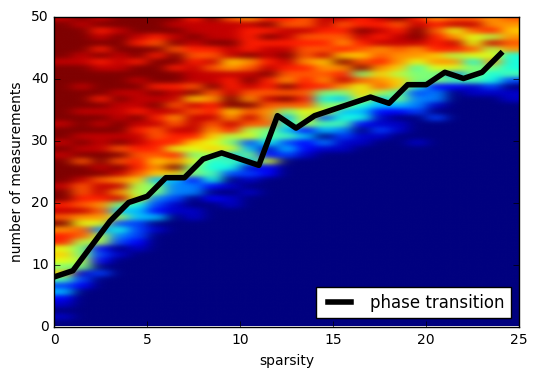

In [33]:
N, nbtest = 50, 16
mat = phase_transition_mat(N, nbtest)# construction of the matrix with the number of success among nbtest

P_min, P_max, S_min, S_max = 0, N, 0, int(N/2)
fig = plt.imshow(mat[P_min:P_max, S_min:S_max], interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent=[S_min, S_max, P_min, P_max])
plt.xlabel('sparsity')
plt.ylabel('number of measurements')

#empirical phase transition
X = range(int(N/2))
L = frontier(mat, nbtest)
plt.plot(X,L, linewidth=4, color = 'black', label='phase transition')
plt.legend(loc=4)

#filename = 'noisy_gaussian_{}_eps_{}.png'.format(n, eps)
#plt.savefig(filename,bbox_inches='tight')

2) Then smooth the obtained phase transition. To do so, repeat the construction of the frontier *nb_curves* times to "smooth it" 

> nb_curves: number of phase transition curves constructed. Those curves are then averaged to "smooth" the effect of randomness in phase transition and get a "stable" phase transition

In [34]:
nb_curves = 5
L = np.zeros(int(N/2))
for i in range(nb_curves):
    if (i % 10) == 0:
        print('step {} done'.format(i))
    mat = phase_transition_mat(N, nbtest)
    F = frontier(mat, nbtest)
    L = [sum(a) for a in zip(L,F)] 
L_gauss = [i/nb_curves for i in L]

step 0 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done


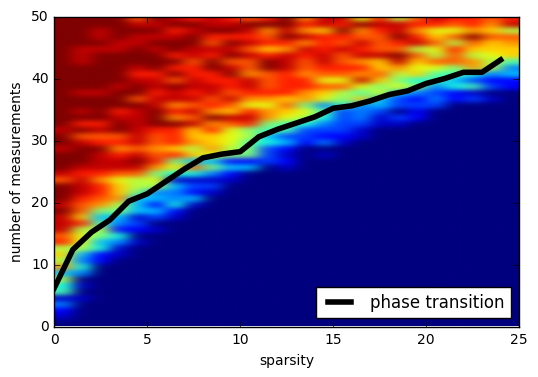

In [35]:
# Display of the smoothed curve
P_min, P_max, S_min, S_max = 0, N, 0, int(N/2)
fig = plt.imshow(mat[P_min:P_max, S_min:S_max], interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent=[S_min, S_max, P_min, P_max])
plt.xlabel('sparsity')
plt.ylabel('number of measurements')

#empirical phase transition
X = range(int(N/2))
plt.plot(X,L_gauss, linewidth=4, color = 'black', label='phase transition')
plt.legend(loc=4)

3) Compare different sensing matrices (Gaussian and student for instance) using their phase transition frontier, what is your conclusion? 

step 0 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
step 0 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done


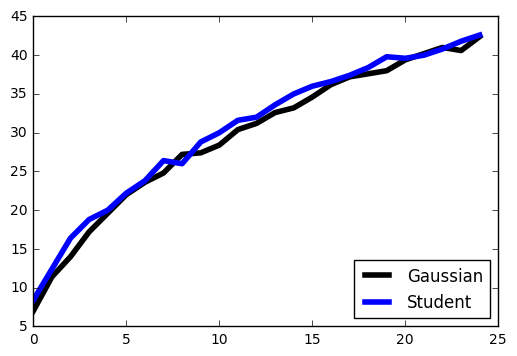

In [36]:
L = np.zeros(int(N/2))
for i in range(nb_curves):
    if (i % 10) == 0:
        print('step {} done'.format(i))
    mat = phase_transition_mat(N, nbtest, "student")
    F = frontier(mat, nbtest)
    L = [sum(a) for a in zip(L,F)] 
L_student = [i/nb_curves for i in L]


X = range(int(N/2))
plt.plot(X,L_gauss, linewidth=4, color = 'black', label='Gaussian')
plt.plot(X,L_student, linewidth=4, color = 'blue', label='Student')
plt.legend(loc=4)